In [1]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as ani

# Necessary classes and functions

City class to represent each city in the square using x and y coordinates

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Fitness class to represent 'How good the route is ?'

In [3]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

Generating edges in the graph randomly

In [4]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [5]:
def plotCities(cityList, title, line=True):
    X = np.array([c.x for c in cityList])
    y = np.array([c.y for c in cityList])
    if line:
        plt.plot(X, y, '-o')
    else:
        plt.scatter(X, y)
    plt.title(title)

# Genetic Algorithm

### 1. Initialisation

In [6]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

### 2. Selection

In [7]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [8]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [9]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

### 3. Crossover

In [10]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [11]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

### 4. Mutation

In [12]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [13]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

### 5. The Next Generation

In [14]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [15]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    popRank = rankRoutes(pop)
    allDists = [1 / popRank[0][1]]
    allRoutes = [pop[popRank[0][0]]]
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        popRank = rankRoutes(pop)
        allDists.append(1 / popRank[0][1])
        allRoutes.append(pop[popRank[0][0]])
    
    return (allDists, allRoutes)

# Running the Genetic Algorithm on Travelling Salesmen Problem

In [16]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 100), y=int(random.random() * 100)))

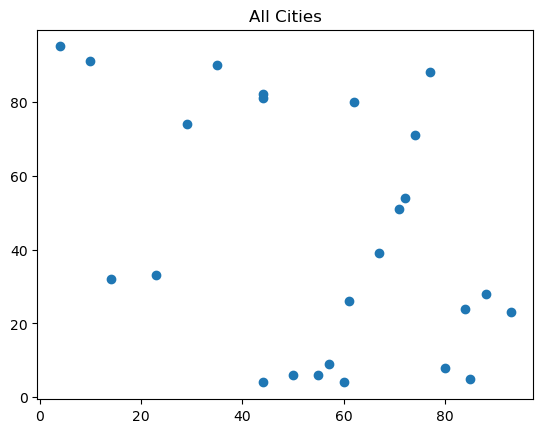

In [17]:
plotCities(cityList, "All Cities", line=False)

In [18]:
allDists, allRoutes = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

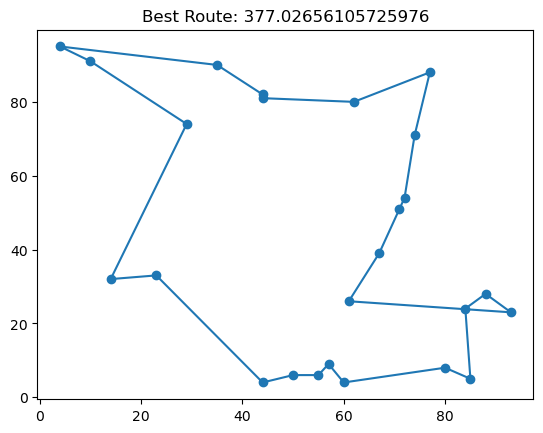

In [19]:
plotCities(allRoutes[-1], f"Best Route: {allDists[-1]}")

# Progress over generations

In [20]:
def plotRouteProgress(allRoutes, allDists, numOfGen):
    n = len(allRoutes)
    diff = n // numOfGen
    for i in range(0, n, diff):
        plotCities(allRoutes[i], f"After {i} generations: {allDists[i]}")
        plt.show()

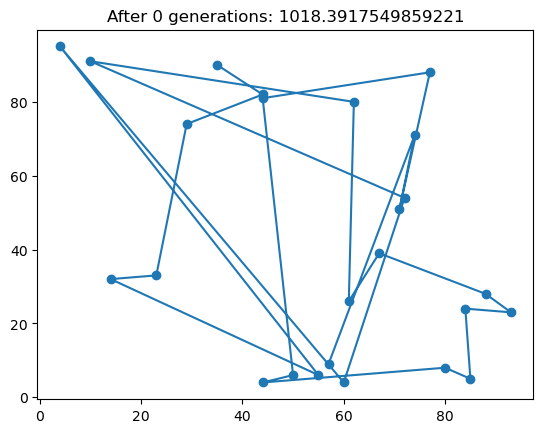

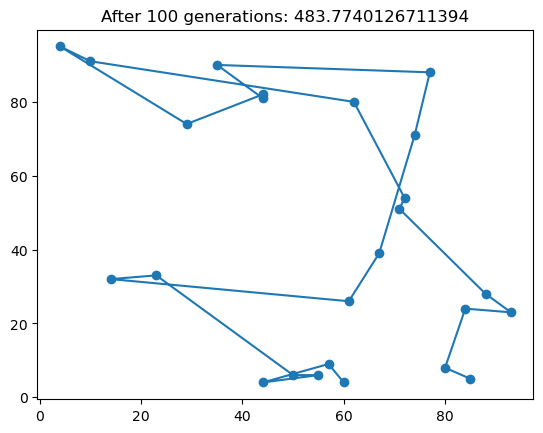

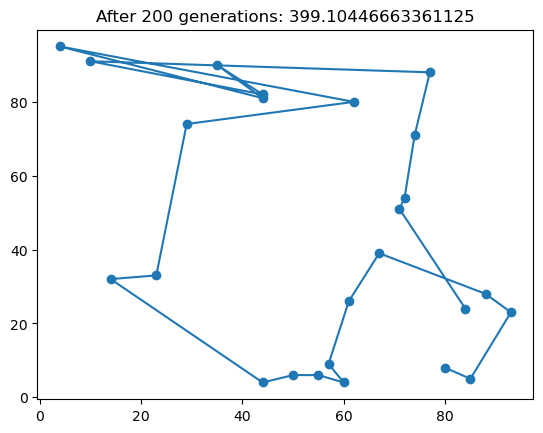

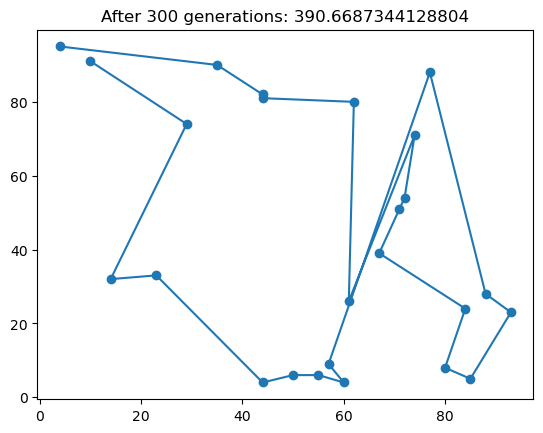

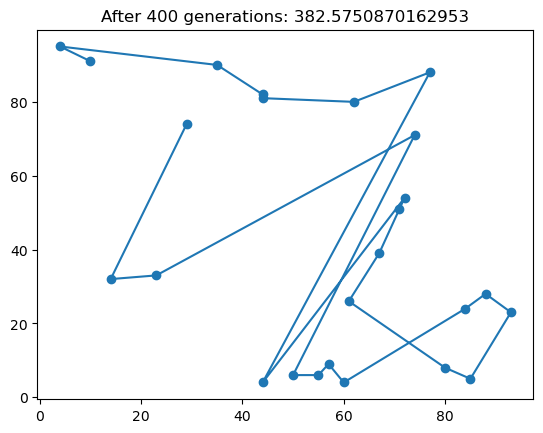

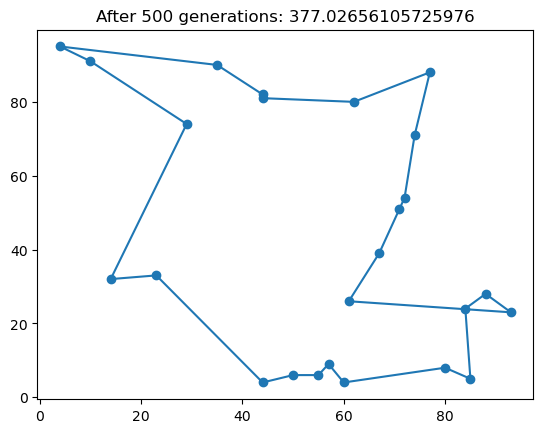

In [21]:
plotRouteProgress(allRoutes, allDists, numOfGen=5)

In [22]:
def plotDist(dist):
    plt.plot(dist)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.title('Distance after every Generation')

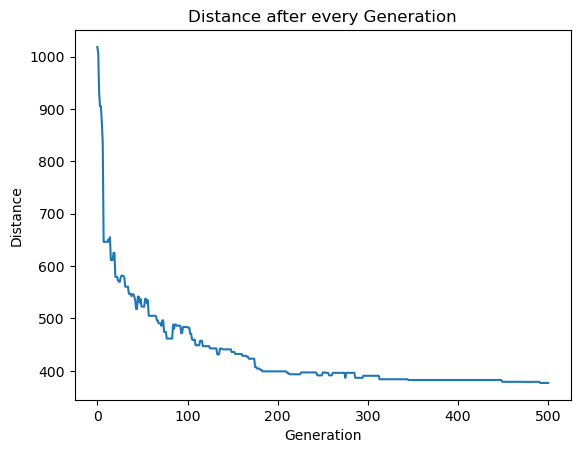

In [23]:
plotDist(allDists)
plt.show()

#### Animating the evolution

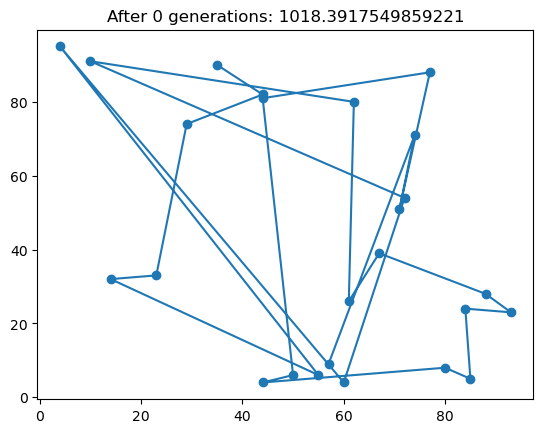

In [24]:
fig_graph = plt.figure()
def build_graph(i):
    plt.cla()
    plotCities(allRoutes[i], f"After {i} generations: {allDists[i]}")

anim_grapg = ani.FuncAnimation(fig_graph, build_graph, frames=range(0,len(allRoutes)), interval=50)
anim_grapg.save('graph.mp4')

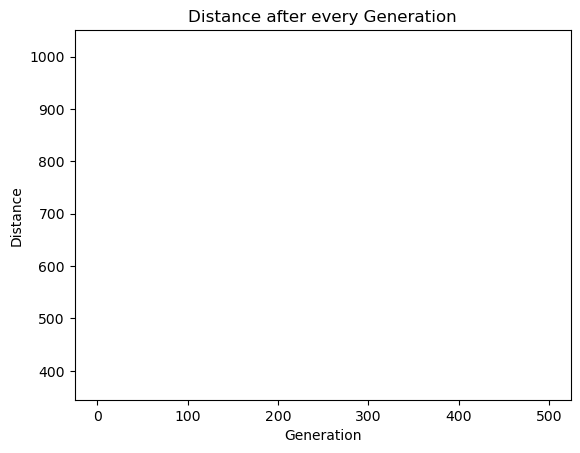

In [25]:
fig_dist = plt.figure()
def build_dist(i):
    plt.cla()
    plotDist(allDists[:i])

anim_dist = ani.FuncAnimation(fig_dist, build_dist, frames=range(len(allDists)), interval=50)
anim_dist.save('distance.mp4')